# Project Overview and Setup

# 📊 SQL-Powered Interactive Sales Data Analysis Dashboard

This notebook demonstrates an end-to-end data science workflow:
1.  **Data Generation:** Create a realistic sales dataset using `pandas` and `numpy`.
2.  **Database Management:** Use `sqlite3` to create a self-contained relational database (`sales_analysis.db`).
3.  **Data Ingestion:** Efficiently load the data into SQLite using `pandas.to_sql()`.
4.  **Advanced SQL Analysis:** Perform key analytical queries using `GROUP BY`, aggregate functions, and date manipulation.
5.  **Data Visualization:** Generate business insights using `matplotlib` and `seaborn`.

This project showcases core skills in database handling, data wrangling, and business intelligence reporting.

# 1. Import Libraries

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")

# 2. Data Generation Function

In [11]:
def generate_sales_data(num_records=150):
    """Generates a realistic Pandas DataFrame for sales analysis."""
    np.random.seed(42)
    products = ['Laptop', 'Smartphone', 'Tablet', 'Monitor']
    regions = ['North', 'South', 'East', 'West']
    
    # Create random dates, products, and regions
    data = {
        'Date': pd.to_datetime(pd.date_range('2023-01-01', periods=num_records)).strftime('%Y-%m-%d'),
        'Product': np.random.choice(products, num_records, p=[0.25, 0.35, 0.15, 0.25]),
        'Region': np.random.choice(regions, num_records, p=[0.3, 0.2, 0.4, 0.1]),
        'Quantity': np.random.randint(5, 50, num_records),
    }
    
    df = pd.DataFrame(data)
    
    # Assign prices, costs, and calculate Sales and Profit
    price_map = {'Laptop': 1200, 'Smartphone': 800, 'Tablet': 450, 'Monitor': 300}
    cost_margin = {'Laptop': 0.7, 'Smartphone': 0.65, 'Tablet': 0.6, 'Monitor': 0.75}
    
    df['Price'] = df['Product'].map(price_map)
    df['Unit_Cost'] = df.apply(lambda row: row['Price'] * cost_margin[row['Product']], axis=1).round(2)
    
    df['Sales'] = df['Quantity'] * df['Price']
    df['Cost'] = df['Quantity'] * df['Unit_Cost']
    df['Profit'] = df['Sales'] - df['Cost']
    
    return df

# Generate the data
sales_df = generate_sales_data(num_records=150)
print(f"Generated {len(sales_df)} sales records.")
sales_df.head()

Generated 150 sales records.


,Date,Product,Region,Quantity,Price,Unit_Cost,Sales,Cost,Profit
0,2023-01-01,Smartphone,West,49,800,520.0,39200,25480.0,13720.0
1,2023-01-02,Monitor,North,36,300,225.0,10800,8100.0,2700.0
2,2023-01-03,Tablet,North,34,450,270.0,15300,9180.0,6120.0
3,2023-01-04,Smartphone,South,39,800,520.0,31200,20280.0,10920.0
4,2023-01-05,Laptop,West,44,1200,840.0,52800,36960.0,15840.0


# 3. Database Setup and Data Ingestion

In [12]:
DB_NAME = 'sales_analysis.db'
TABLE_NAME = 'sales'

# Connect to the SQLite database (creates the file if it doesn't exist)
conn = sqlite3.connect(DB_NAME)

# Ingest the DataFrame into the SQLite table
print(f"Ingesting data into SQLite table '{TABLE_NAME}'...")
# 'if_exists="replace"' ensures a fresh table every time this cell is run
sales_df.to_sql(TABLE_NAME, conn, if_exists='replace', index=False)
print("Data ingestion complete.")

# Verify the table creation by querying the schema
cursor = conn.cursor()
cursor.execute(f"PRAGMA table_info({TABLE_NAME})")
print("\nTable Schema:")
for col in cursor.fetchall():
    print(f"- {col[1]} ({col[2]})")

# A simple SELECT to confirm data presence
print("\nFirst 5 rows from the database:")
pd.read_sql_query(f"SELECT * FROM {TABLE_NAME} LIMIT 5", conn)

Ingesting data into SQLite table 'sales'...
Data ingestion complete.

Table Schema:
- Date (TEXT)
- Product (TEXT)
- Region (TEXT)
- Quantity (INTEGER)
- Price (INTEGER)
- Unit_Cost (REAL)
- Sales (INTEGER)
- Cost (REAL)
- Profit (REAL)

First 5 rows from the database:


,Date,Product,Region,Quantity,Price,Unit_Cost,Sales,Cost,Profit
0,2023-01-01,Smartphone,West,49,800,520.0,39200,25480.0,13720.0
1,2023-01-02,Monitor,North,36,300,225.0,10800,8100.0,2700.0
2,2023-01-03,Tablet,North,34,450,270.0,15300,9180.0,6120.0
3,2023-01-04,Smartphone,South,39,800,520.0,31200,20280.0,10920.0
4,2023-01-05,Laptop,West,44,1200,840.0,52800,36960.0,15840.0


# 4. Advanced SQL Analysis: Product Performance

--- Running Analysis Query 1: Sales & Profit by Product ---
      Product  Total_Sales  Total_Profit
0      Laptop      1420800      426240.0
1  Smartphone      1135200      397320.0
2     Monitor       325500       81375.0
3      Tablet       203850       81540.0


C:\Users\admin\AppData\Local\Temp\ipykernel_30796\1470657123.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product', y='Total_Sales', data=product_summary_df, palette='viridis')


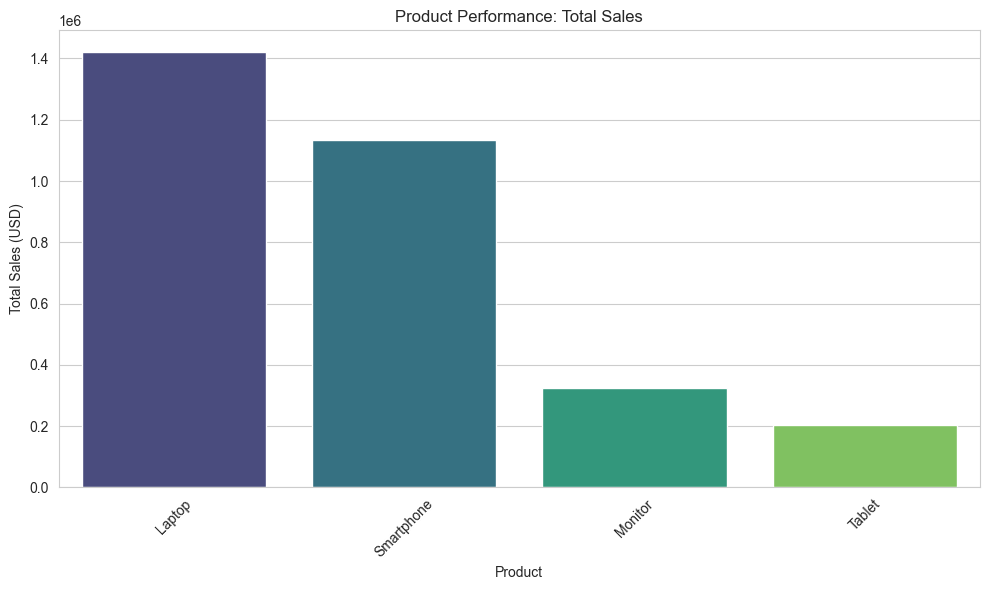

In [13]:
# Query 1: Total Sales and Profit by Product (GROUP BY & Aggregate)
print("--- Running Analysis Query 1: Sales & Profit by Product ---")

query_product_summary = """
SELECT 
    Product, 
    SUM(Sales) AS Total_Sales, 
    SUM(Profit) AS Total_Profit
FROM sales 
GROUP BY Product 
ORDER BY Total_Sales DESC;
"""

# Fetch the results directly into a DataFrame for easy visualization
product_summary_df = pd.read_sql_query(query_product_summary, conn)
print(product_summary_df)

# Visualization 1: Total Sales by Product (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x='Product', y='Total_Sales', data=product_summary_df, palette='viridis')
plt.title('Product Performance: Total Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Advanced SQL Analysis: Monthly Trend


--- Running Analysis Query 2: Monthly Sales Trend ---
  Sale_Month  Monthly_Sales
0    2023-01         673500
1    2023-02         567350
2    2023-03         581650
3    2023-04         623850
4    2023-05         639000


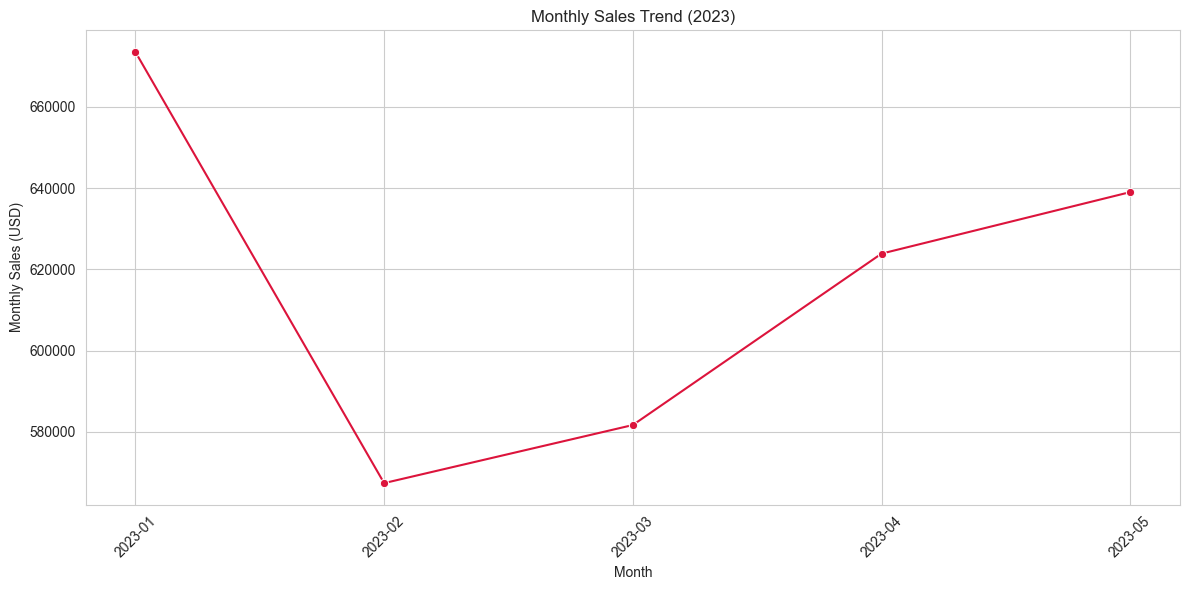

In [14]:
# Query 2: Monthly Sales Trend (Date manipulation with strftime & GROUP BY)
print("\n--- Running Analysis Query 2: Monthly Sales Trend ---")

query_monthly_trend = """
SELECT 
    -- strftime extracts the year-month part of the date for grouping
    strftime('%Y-%m', Date) AS Sale_Month, 
    SUM(Sales) AS Monthly_Sales
FROM sales 
GROUP BY Sale_Month
ORDER BY Sale_Month;
"""

monthly_trend_df = pd.read_sql_query(query_monthly_trend, conn)
print(monthly_trend_df)

# Visualization 2: Monthly Sales Trend (Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sale_Month', y='Monthly_Sales', data=monthly_trend_df, marker='o', color='crimson')
plt.title('Monthly Sales Trend (2023)')
plt.xlabel('Month')
plt.ylabel('Monthly Sales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Advanced SQL Analysis: Regional Breakdown


--- Running Analysis Query 3: Top 3 Regions by Quantity ---
  Region  Total_Quantity
0   East            1957
1  North            1244
2  South             497


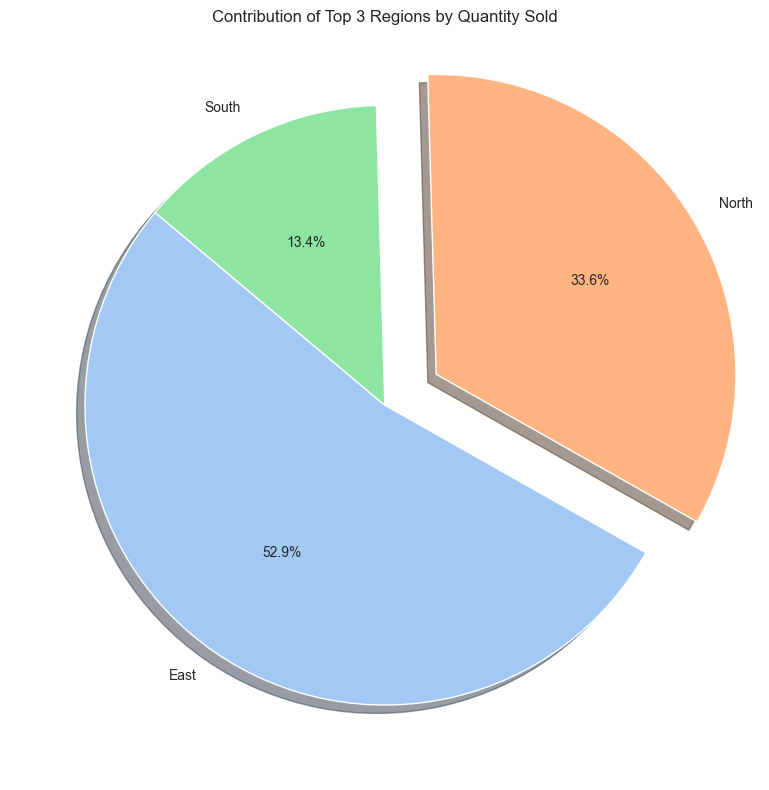

In [15]:
# Query 3: Top 3 Regions by Quantity Sold (ORDER BY & LIMIT)
print("\n--- Running Analysis Query 3: Top 3 Regions by Quantity ---")

query_top_regions = """
SELECT 
    Region, 
    SUM(Quantity) AS Total_Quantity
FROM sales 
GROUP BY Region
ORDER BY Total_Quantity DESC
LIMIT 3;
"""

top_regions_df = pd.read_sql_query(query_top_regions, conn)
print(top_regions_df)

# Visualization 3: Top Regions by Quantity (Pie Chart)
plt.figure(figsize=(8, 8))
explode = (0, 0.2, 0)  # explode all slices for emphasis
plt.pie(
    top_regions_df['Total_Quantity'], 
    labels=top_regions_df['Region'], 
    explode=explode,
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('pastel'),
    shadow=True
)
plt.title('Contribution of Top 3 Regions by Quantity Sold')
plt.tight_layout()
plt.show()

# 7. Cleanup and Closing

In [16]:
# Close the database connection
if conn:
    conn.close()
    print("\nDatabase connection closed successfully.")



Database connection closed successfully.
